In [1]:
## Import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import mlflow
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
################
## Generate data
################


# Set random seed for reproducibility
np.random.seed(42)

# Number of rows to be generated
n_rows = 10000

# Generate descriptive variables
age = np.random.randint(18, 71, size=n_rows)
gender = np.random.choice(['Male', 'Female'], size=n_rows)
geographical_area = np.random.randint(1, 6, size=n_rows)
invoicing = np.random.normal(loc=120, scale=20, size=n_rows)
usage_amount = np.random.normal(loc=50, scale=10, size=n_rows)
product_flag = np.random.choice([0, 1], size=n_rows)

# Create a DataFrame
df = pd.DataFrame({
    'age': age,
    'gender': gender,
    'geographical_area': geographical_area,
    'invoicing': invoicing,
    'usage_amount': usage_amount,
    'product_flag': product_flag
})


# Make gender a binary flag
label_encoder = LabelEncoder()

df['gender_binary'] = label_encoder.fit_transform(df['gender'])


# Introduce correlation between age and invoicing
df['invoicing'] += df['age'] * 5

# Introduce correlation between product flag and invoicing
df['invoicing'] += df['product_flag'] * 120

# Introduce correlation between usage and invoicing
df['invoicing'] += df['usage_amount'] * 10



# Generate target variable so that it depends on selected features, include small random variation
linear_combination = -25 + 0.05 * df['age'] + 0.02 * df['invoicing']
random_variation =  0.1 * np.random.normal(0, 1, size=len(df))

probability = 1 / (1 + np.exp(-linear_combination))
df['target'] = np.random.binomial(1, probability)
df['probability'] = probability
df['linear_combination'] = linear_combination
df['random'] = random_variation


print('Target distribution:')
print(df['target'].value_counts())
print('\nFirst rows of data:')
df.head(10)

Target distribution:
target
0    9030
1     970
Name: count, dtype: int64

First rows of data:


,age,gender,geographical_area,invoicing,usage_amount,product_flag,gender_binary,target,probability,linear_combination,random
0,56,Male,3,990.822050,45.137949,1,1,0,0.084435,-2.383559,-0.060410
1,69,Female,2,1214.058278,60.601857,1,0,1,0.938841,2.731166,0.124315
2,46,Male,3,919.854548,59.068388,0,1,0,0.013349,-4.302909,-0.135310
3,32,Female,4,976.366058,57.308048,1,0,0,0.020379,-3.872679,0.191157
4,60,Male,1,1178.770268,65.078313,1,1,1,0.828553,1.575405,-0.018502
5,25,Male,5,847.897505,50.062975,1,1,0,0.001121,-6.792050,-0.136209
6,38,Female,1,948.466477,51.758938,1,0,0,0.015818,-4.130670,0.038982
7,56,Male,4,836.981312,30.070346,1,1,0,0.004234,-5.460374,0.018276
8,36,Female,5,697.095139,40.899813,0,0,0,0.000095,-9.258097,-0.015379
9,40,Female,3,997.730684,55.114726,1,0,0,0.045417,-3.045386,-0.062986


In [6]:
######################
## Logistic Regression
######################

# Select features to be used out of ['age', 'gender_binary', 'geographical_area', 'invoicing', 'usage_amount', 'product_flag']
features = ['age', 'invoicing']

# Split data to training and testing partitions
X_train, X_test, y_train, y_test = train_test_split(df[features], df['target'], test_size=0.25, random_state=42)

print('Number of rows in training data:', len(X_train))

# Fit the model, use regularization hyperparameter 0.01
model_logreg = LogisticRegression(random_state=42)
reg = 0.001
model_logreg = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)

# Display model equation
intercept = model_logreg.intercept_[0]
coefficients = model_logreg.coef_[0]

equation = f"Logit(P) = {intercept:.4f}"
for feature, coef in zip(X_train.columns, coefficients):
    equation += f" + ({coef:.4f} * {feature})"

print("Logistic Regression Equation:", equation)

odds_ratios = np.exp(model_logreg.coef_)
print(f'Odds Ratios: {odds_ratios}')

Number of rows in training data: 7500
Logistic Regression Equation: Logit(P) = -20.7978 + (0.0406 * age) + (0.0165 * invoicing)
Odds Ratios: [[1.04140215 1.01661   ]]


In [12]:
print(odds_ratios

IndexError: index 1 is out of bounds for axis 0 with size 1

In [4]:
##################################################
## Evaluate the model based on test data partition
##################################################


# Predicted value in test set (y_pred contains what is predicted based on X_pred data by the model, and y_test contains the true outcome):
y_pred = model_logreg.predict(X_test)

# Calculate true/false poritices/negatives
print('Classification outcomes:')
correct = y_test == y_pred
tp = np.sum(correct & y_test)
tn = np.sum(correct & np.logical_not(y_test))
fp = np.sum(np.logical_not(correct) & y_test)
fn = np.sum(np.logical_not(correct) & np.logical_not(y_test))

print("TP - True Positives: ", tp)
print("TN - True Negatives: ", tn)
print("FP - False positives: ", fp)
print("FN - False negatives: ", fn)


# Confusion matrix
print('\n')
print('Confusion matrix:')
cnf_matrix = metrics.confusion_matrix(y_test, y_pred, normalize=None)
print(cnf_matrix)


# Other metrics
accuracy = np.average(y_pred == y_test) # Accuracy
auc = metrics.roc_auc_score(y_test,y_pred) # Area under ROC curve
sensitivity = tp / (tp + fn) # out of all actual positives, how many are correctly predicted (ie. recall)
specificity = tn / (tn + fp) # out of all actual negatives, how many are correctly predicted
precision = tp / (tp + fp) # out of all positive predidtions, how many are true positives
false_positive_rate = fp / (fp + tn)

print('\n')
print('Other metrics:')
print('AUC: ', auc)
print('Accuracy:', accuracy)
print('Sensitivity/recall:', sensitivity)
print('Specificity: ', specificity)
print('Precision: ', precision)
print('False positive rate: ',false_positive_rate)

Classification outcomes:
TP - True Positives:  107
TN - True Negatives:  2231
FP - False positives:  120
FN - False negatives:  42


Confusion matrix:
[[2231   42]
 [ 120  107]]


Other metrics:
AUC:  0.7264439280502198
Accuracy: 0.9352
Sensitivity/recall: 0.7181208053691275
Specificity:  0.9489578902594641
Precision:  0.4713656387665198
False positive rate:  0.05104210974053594


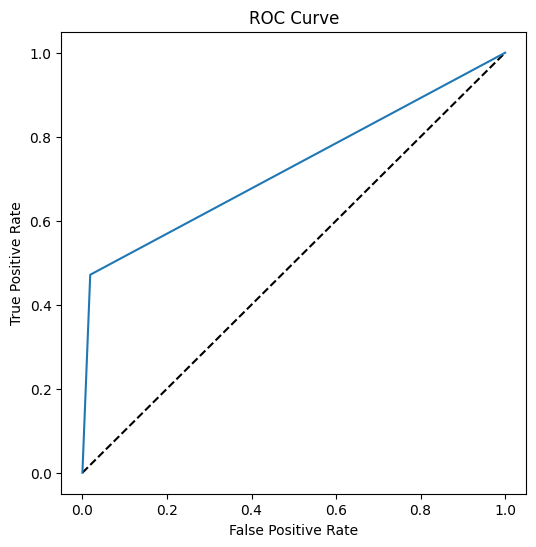

In [6]:
# Plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()